# Item-Item Collaborative Filtering using Pearson Correlation

We now implement the core of our recommendation system using item-item collaborative filtering. This approach is based on the idea that similar items tend to be rated similarly by users.

Unlike user-based approaches, item-based collaborative filtering builds a model of item similarities that's more stable over time, since item properties change less frequently than user preferences.

In [1]:
import pandas as pd
import numpy as np
import os

def load_ratings():
    """Load ratings dataset, either from filtered file if exists or process the full dataset"""
    if os.path.exists("filtered_ratings.csv"):
        print(f"Loading pre-filtered ratings from filtered_ratings.csv")
        return pd.read_csv("filtered_ratings.csv")
    else:
        print("Filtered ratings file not found. Please run the data processing steps first.")
        return None
    

# Load the filtered ratings dataset
ratings = load_ratings()
print(f"Loaded {len(ratings)} ratings from {ratings['userId'].nunique()} users on {ratings['movieId'].nunique()} movies")

# Let's also load the cleaned movies data
movies = pd.read_csv('movies_metadata.csv', low_memory=False)
print(f"Loaded {len(movies)} movies from metadata")


# Calculate the mean rating for each user
user_mean_ratings = ratings.groupby('userId')['rating'].mean()

# Create function to normalize ratings
def normalize_rating(row):
    return row['rating'] - user_mean_ratings[row['userId']]

# Add normalized ratings
ratings['rating_norm'] = ratings.apply(normalize_rating, axis=1)

ratings_with_info = ratings

# Display sample to see both original and normalized ratings
print("Sample ratings with normalization:")
sample_users = ratings['userId'].unique()[:3]
sample_data = ratings[ratings['userId'].isin(sample_users)].head(10)
sample_data


Loading pre-filtered ratings from filtered_ratings.csv
Loaded 6749644 ratings from 103839 users on 9976 movies
Loaded 45466 movies from metadata
Sample ratings with normalization:


,userId,movieId,rating,timestamp,rating_norm
0,82193,1,4.0,2010-10-20 01:00:49,0.782468
1,153907,1,4.0,2011-07-23 16:52:35,-0.028302
2,212739,1,3.0,2016-01-13 23:09:30,-0.302817
43939,82193,244,0.5,2010-10-21 15:51:58,-2.717532
60186,82193,330,3.0,2010-10-20 22:01:58,-0.217532
65268,82193,355,3.5,2010-10-20 18:11:24,0.282468
70763,82193,382,3.5,2010-10-20 18:57:49,0.282468
79338,82193,437,2.5,2011-01-21 03:28:14,-0.717532
101839,82193,553,3.5,2010-10-20 17:54:40,0.282468
119369,82193,674,4.0,2010-10-27 00:24:54,0.782468


In [2]:
# Create the sparse matrix using pivot_table
ratings_matrix = ratings.pivot_table(
    index='userId', 
    columns='movieId', 
    values='rating_norm'  # Using normalized ratings
)

print(f"Created ratings matrix with shape: {ratings_matrix.shape}")

# Let's see a small sample of the matrix
print("\nSample of the user-item ratings matrix:")
ratings_matrix.iloc[:5, :5]

Created ratings matrix with shape: (103839, 9976)

Sample of the user-item ratings matrix:


movieId,1,2,3,4,5
userId,,,,,
4,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN


In [3]:
# Clean the movies dataset
# First, let's check what columns are available
print("Movies dataset columns:")
print(movies.columns.tolist())

# For item-item collaborative filtering, we only need minimal movie information
# Keep only id, title, and maybe genres
movies_cleaned = movies[['id', 'title', 'genres']].copy()

# Convert id to int to match with movieId in ratings
# Some IDs might not be convertible to int, so we'll handle exceptions
def safe_convert_id(x):
    try:
        return int(float(x))
    except (ValueError, TypeError):
        return None

movies_cleaned['id'] = movies_cleaned['id'].apply(safe_convert_id)
movies_cleaned = movies_cleaned.dropna(subset=['id'])
movies_cleaned['id'] = movies_cleaned['id'].astype(int)

# Rename 'id' to 'movieId' to match ratings dataframe
movies_cleaned = movies_cleaned.rename(columns={'id': 'movieId'})

# Parse genres from JSON string format if necessary
import json
import ast

def extract_genres(genres_str):
    try:
        if isinstance(genres_str, str):
            # Try to parse as JSON first
            try:
                genres_list = json.loads(genres_str.replace("'", '"'))
            except:
                # If that fails, try ast.literal_eval
                try:
                    genres_list = ast.literal_eval(genres_str)
                except:
                    return []
                
            # Extract genre names
            return [g['name'] for g in genres_list if 'name' in g]
    except:
        pass
    return []

movies_cleaned['genres_list'] = movies_cleaned['genres'].apply(extract_genres)
movies_cleaned['genres_str'] = movies_cleaned['genres_list'].apply(lambda x: ', '.join(x))

# Drop the original genres column and the intermediate list
movies_cleaned = movies_cleaned.drop(columns=['genres', 'genres_list'])

# Display the cleaned movies data
print(f"\nCleaned movies data: {len(movies_cleaned)} entries")
movies_cleaned.head()

Movies dataset columns:
['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']

Cleaned movies data: 45463 entries


,movieId,title,genres_str
0,862,Toy Story,"Animation, Comedy, Family"
1,8844,Jumanji,"Adventure, Fantasy, Family"
2,15602,Grumpier Old Men,"Romance, Comedy"
3,31357,Waiting to Exhale,"Comedy, Drama, Romance"
4,11862,Father of the Bride Part II,Comedy


In [ ]:
# Function to predict a user's rating for an item
def predict_rating(user_id, movie_id, k=10):
    """Predict a user's rating for a movie using item-based collaborative filtering
    
    Args:
        user_id (int): User ID
        movie_id (int): Movie ID
        k (int): Number of similar items to consider
        
    Returns:
        float: Predicted rating
    """
    # If user or movie not in our data, return None
    if user_id not in ratings_matrix.index or movie_id not in item_similarity:
        return None
    
    # Get the user's ratings
    user_ratings = ratings_matrix.loc[user_id]
    
    # Get similar movies that the user has rated
    if movie_id not in item_similarity:
        return None
        
    similarities = item_similarity[movie_id]
    rated_similar = []
    
    for similar_id, sim in similarities.items():
        if similar_id in user_ratings and not np.isnan(user_ratings[similar_id]):
            rated_similar.append((similar_id, sim, user_ratings[similar_id]))
    
    if not rated_similar:
        return None
    
    # Sort by similarity and take top k
    rated_similar.sort(key=lambda x: abs(x[1]), reverse=True)
    rated_similar = rated_similar[:k]
    
    # Calculate weighted average rating
    numerator = sum(sim * rating for _, sim, rating in rated_similar)
    denominator = sum(abs(sim) for _, sim, _ in rated_similar)
    
    if denominator == 0:
        return None
        
    # Get the user's average rating to add back (since we used normalized ratings)
    user_mean = user_mean_ratings[user_id]
    
    # Return predicted rating
    predicted = numerator / denominator + user_mean
    return min(max(predicted, 0.5), 5.0)  # Clip to valid rating range

## Building the Similarity Function

We'll use the Pearson correlation coefficient to measure similarity between items. This metric captures linear relationships between item ratings while accounting for differences in mean and variance, making it robust to different user rating scales.

In [ ]:
# Calculate item-item similarity using Pearson correlation coefficient
from scipy.stats import pearsonr
import numpy as np

# Transpose the ratings matrix so columns are users and rows are items
# This makes it easier to compute item-item similarity
item_user_matrix = ratings_matrix.T

print(f"Item-user matrix shape: {item_user_matrix.shape}")

# Function to compute Pearson correlation between two items
def compute_pearson_similarity(item1, item2):
    # Get ratings for both items, only considering users who rated both
    common_users = item1.notna() & item2.notna()
    if common_users.sum() < 5:  # Need at least 5 common ratings for reliability
        return 0
        
    item1_ratings = item1[common_users]
    item2_ratings = item2[common_users]
    
    if len(item1_ratings) == 0 or np.std(item1_ratings) == 0 or np.std(item2_ratings) == 0:
        return 0
        
    try:
        corr, _ = pearsonr(item1_ratings, item2_ratings)
        return corr if not np.isnan(corr) else 0
    except:
        return 0

Item-user matrix shape: (3070, 103839)


## Defining the Scope of Analysis

Computing similarities between all possible movie pairs would be computationally prohibitive. We focus on the most frequently rated movies for two reasons:

1. They have more data points for reliable similarity calculations
2. They're likely to be more relevant for recommendations

In [ ]:
#  Since computing the full similarity matrix might be computationally expensive,
#  we'll limit our analysis to the top N most-rated movies
num_top_movies = 3000

# Get the most rated movies
movie_ratings_count = ratings_with_info['movieId'].value_counts()
top_rated_movies = movie_ratings_count.nlargest(num_top_movies).index.tolist()


## Computing Item-Item Similarity Matrix

This is the most computationally intensive part of our process. We'll calculate pairwise similarity between movies using the Pearson correlation of their ratings. We only store meaningful correlations (above a threshold of 0.2) to save memory and improve efficiency.

In [ ]:

print(f"Computing similarity for the top {num_top_movies} most rated movies...")

# Create a dictionary to store similar items for each movie
item_similarity = {}

# For each movie in our top list, find its similarity with all other movies
for i, movie_id in enumerate(top_rated_movies):
    if i % 100 == 0:
        print(f"Processing movie {i}/{len(top_rated_movies)}")
        
    # Skip if movie is not in our item_user_matrix
    if movie_id not in item_user_matrix.index:
        continue
        
    item1 = item_user_matrix.loc[movie_id]
    item_similarity[movie_id] = {}
    
    for other_movie_id in top_rated_movies:
        if movie_id == other_movie_id or other_movie_id not in item_user_matrix.index:
            continue
            
        item2 = item_user_matrix.loc[other_movie_id]
        sim = compute_pearson_similarity(item1, item2)
        
        # Only keep significant similarities
        if abs(sim) > 0.2:  # Threshold for meaningful correlation
            item_similarity[movie_id][other_movie_id] = sim

print("Similarity computation complete!")

# Hyperparameter Tuning

To optimize our recommendation system, we need to tune several key hyperparameters that significantly impact performance. Finding the right values for these parameters can substantially improve accuracy.

## Optimizing the Number of Neighbors (k)

The number of similar items to consider when making predictions is a critical parameter. Too few neighbors might not capture enough information, while too many might introduce noise. We'll systematically test different values to find the optimal balance.

# Time-Aware Recommendations

In many recommendation scenarios, newer items are more relevant than older ones. For movie recommendations, recent releases might be more interesting to users than older films. We'll enhance our recommendation system by incorporating release year information to prioritize newer movies.

## Extracting Release Year from Movie Metadata

First, we need to extract the release year from the movie data. The movies_metadata.csv file contains release date information that we can parse to get the year.

Date-related columns: ['release_date']
  release_date
0   1995-10-30
1   1995-12-15
2   1995-12-22
3   1995-12-22
4   1995-02-10

Movie release year distribution:
Earliest year: 1900, Latest year: 2020
Most common year: 2014 with 1974 movies


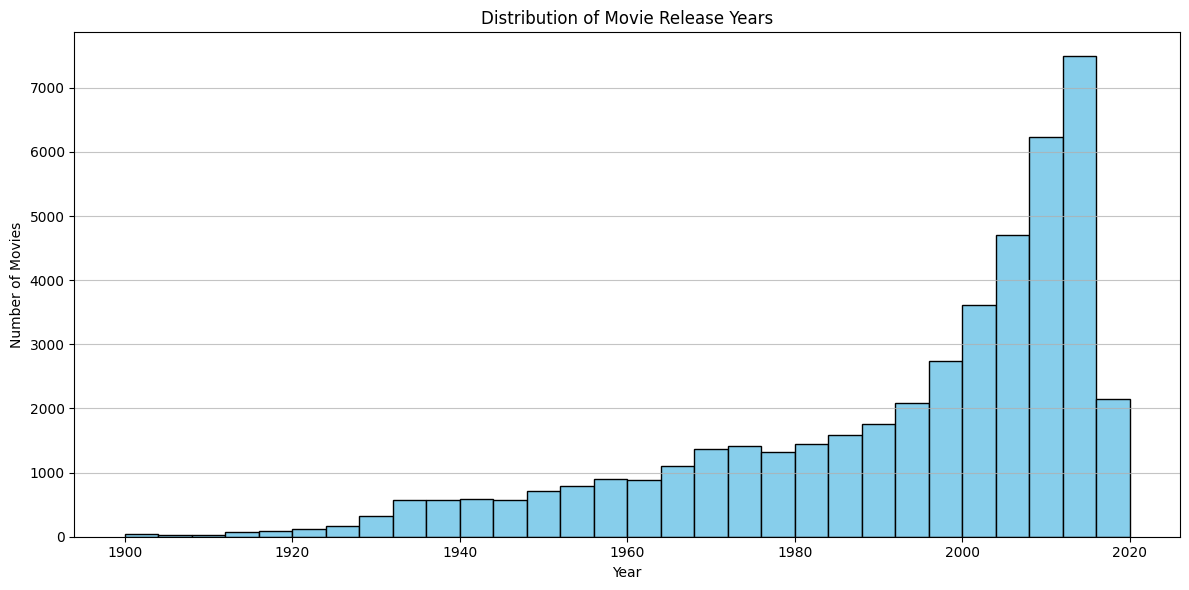

In [ ]:
# Load the original movies metadata to access release dates
original_movies = pd.read_csv('../movies_data/movies_metadata.csv', low_memory=False)

# Display the columns related to release date
date_columns = [col for col in original_movies.columns if 'date' in col.lower() or 'year' in col.lower()]
print(f"Date-related columns: {date_columns}")
print(original_movies[date_columns].head())

# Extract release year from release_date
def extract_year(date_str):
    """Extract the year from a date string in format YYYY-MM-DD"""
    try:
        if pd.isna(date_str) or date_str == '':
            return None
        # Try to extract year from YYYY-MM-DD format
        year = str(date_str).split('-')[0]
        # Check if it's a valid 4-digit year
        if year.isdigit() and len(year) == 4 and 1900 <= int(year) <= 2023:
            return int(year)
        return None
    except:
        return None

# Add release year to our cleaned movies dataset
# First create a mapping from movieId to release year
id_to_year = {}
for _, row in original_movies.iterrows():
    try:
        movie_id = int(float(row['id']))
        year = extract_year(row.get('release_date', None))
        if year is not None:
            id_to_year[movie_id] = year
    except:
        pass

# Add release year to movies_cleaned
movies_cleaned['release_year'] = movies_cleaned['movieId'].map(id_to_year)

# Fill missing years with the median year
median_year = movies_cleaned['release_year'].median()
movies_cleaned['release_year'] = movies_cleaned['release_year'].fillna(median_year).astype(int)

# Display distribution of movie release years
print("\nMovie release year distribution:")
year_counts = movies_cleaned['release_year'].value_counts().sort_index()
print(f"Earliest year: {year_counts.index.min()}, Latest year: {year_counts.index.max()}")
print(f"Most common year: {movies_cleaned['release_year'].value_counts().idxmax()} with {movies_cleaned['release_year'].value_counts().max()} movies")

# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(movies_cleaned['release_year'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Release Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

## Implementing Time Bias in Recommendations

Now we'll implement a time bias function that gives higher preference to newer movies. This bias will adjust the predicted ratings based on the movie's release year.

Time bias values for different release years:
Year 2025: bias = 1.0000
Year 2020: bias = 0.9500
Year 2015: bias = 0.9000
Year 2010: bias = 0.8500
Year 2000: bias = 0.7500
Year 1990: bias = 0.6500
Year 1980: bias = 0.5500
Year 1970: bias = 0.5000
Year 1950: bias = 0.5000


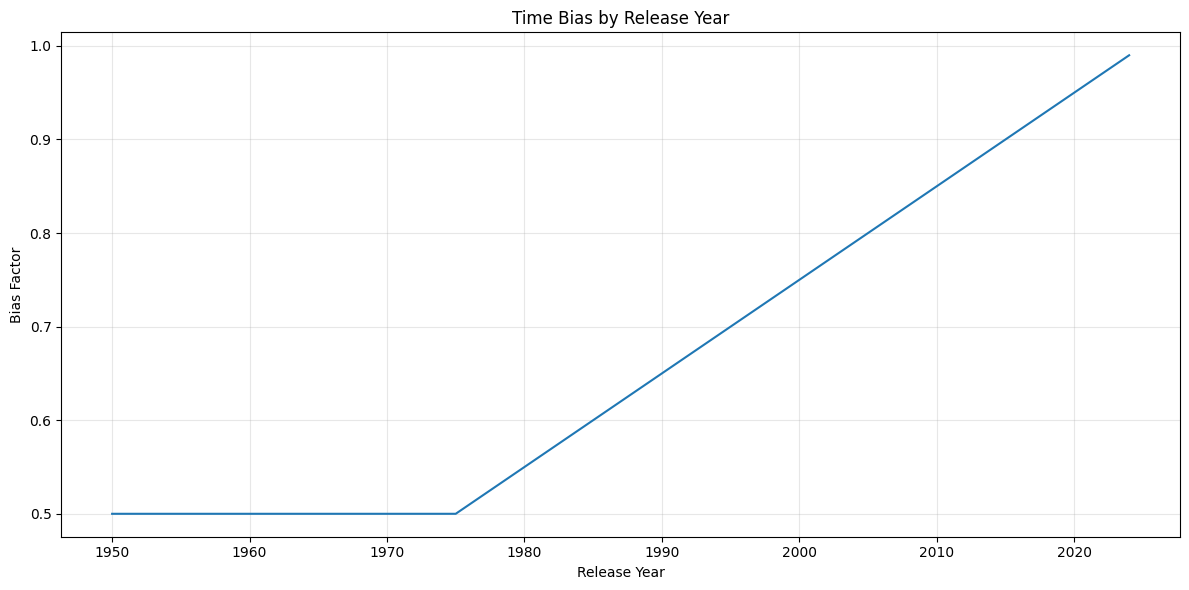

In [ ]:
# Define a function to calculate time bias
def calculate_time_bias(release_year, current_year=2025, max_age=50, bias_strength=0.5):
    """Calculate a bias factor based on movie age.
    
    Args:
        release_year: The year the movie was released
        current_year: Current year (default: 2023)
        max_age: Age at which bias reaches maximum penalty (default: 50 years)
        bias_strength: How strong the bias should be (0-1, default: 0.5)
        
    Returns:
        float: A bias factor between 0 and 1, where newer movies get values closer to 1
    """
    # Calculate movie age
    age = max(0, current_year - release_year)
    
    # Normalize age to 0-1 range, capped at max_age
    normalized_age = min(1.0, age / max_age)
    
    # Calculate bias factor (1 for newest, decreasing for older)
    # The bias_strength parameter controls how quickly the bias decreases
    bias = 1.0 - (normalized_age * bias_strength)
    
    return bias

# Test the bias function with some example years
test_years = [2025, 2020, 2015, 2010, 2000, 1990, 1980, 1970, 1950]
print("Time bias values for different release years:")
for year in test_years:
    bias = calculate_time_bias(year)
    print(f"Year {year}: bias = {bias:.4f}")

# Visualize the time bias function
years = range(1950, 2025)
biases = [calculate_time_bias(year) for year in years]

plt.figure(figsize=(12, 6))
plt.plot(years, biases)
plt.title('Time Bias by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Bias Factor')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Implementing Time-Aware Recommendations

Now let's update our recommendation function to incorporate the time bias. We'll create two variations:

1. A version that applies the time bias as a post-processing step
2. A version that integrates the time bias directly into the rating prediction process

In [ ]:
# Updated recommendation function with time bias
def recommend_movies_with_time_bias(user_id, n=10, min_ratings=5, bias_strength=0.5, post_process=True):
    """Generate movie recommendations with time bias for a user
    
    Args:
        user_id (int): User ID
        n (int): Number of recommendations to generate
        min_ratings (int): Minimum number of ratings a movie should have
        bias_strength (float): Strength of the time bias (0-1)
        post_process (bool): If True, apply time bias after rating prediction;
                            If False, integrate into the prediction process
        
    Returns:
        list: List of (movie_id, title, predicted_rating, release_year) tuples
    """
    # If user not in our data, return empty list
    if user_id not in ratings_matrix.index:
        return []
        
    # Get movies the user hasn't rated
    user_rated_movies = set(ratings_with_info[ratings_with_info['userId'] == user_id]['movieId'])
    candidate_movies = [
        movie_id for movie_id in top_rated_movies 
        if movie_id not in user_rated_movies
    ]
    
    # Calculate predicted ratings
    predictions = []
    for movie_id in candidate_movies:
        # Skip movies with too few ratings
        if movie_ratings_count.get(movie_id, 0) < min_ratings:
            continue
            
        # Get basic prediction
        predicted = predict_rating(user_id, movie_id)
        
        if predicted is not None:
            # Get movie metadata
            movie_info = movies_cleaned[movies_cleaned['movieId'] == movie_id]
            if len(movie_info) > 0:
                title = movie_info['title'].values[0]
                release_year = movie_info['release_year'].values[0]
                
                if post_process:
                    # Post-processing approach: Apply time bias to predicted rating
                    time_bias = calculate_time_bias(release_year, bias_strength=bias_strength)
                    # Adjust prediction using the bias
                    # This formula blends the original rating with the time bias
                    # as bias_strength increases, newer movies get higher boost
                    adjusted_rating = predicted * (1 + (time_bias - 0.5) * bias_strength)
                    # Ensure the rating stays within valid range
                    adjusted_rating = min(max(adjusted_rating, 0.5), 5.0)
                    
                    predictions.append((movie_id, title, adjusted_rating, release_year))
                else:
                    # Just store the regular prediction for now; we'll modify the prediction function later
                    predictions.append((movie_id, title, predicted, release_year))
    
    # Sort by predicted rating (descending) and return top n
    predictions.sort(key=lambda x: x[2], reverse=True)
    return predictions[:n]

# Let's update predict_rating to incorporate time bias if needed
def predict_rating_with_time(user_id, movie_id, k=10, bias_strength=0.5):
    """Predict a user's rating for a movie using item-based CF with time bias
    
    This version integrates time bias directly into the prediction process
    """
    # First get the basic prediction
    basic_prediction = predict_rating(user_id, movie_id, k)
    
    if basic_prediction is None:
        return None
    
    # Get movie release year
    movie_info = movies_cleaned[movies_cleaned['movieId'] == movie_id]
    if len(movie_info) > 0:
        release_year = movie_info['release_year'].values[0]
        
        # Calculate time bias
        time_bias = calculate_time_bias(release_year, bias_strength=bias_strength)
        
        # Adjust prediction - boost newer movies, decrease older ones
        adjusted_prediction = basic_prediction * (1 + (time_bias - 0.5) * bias_strength)
        
        # Ensure prediction stays in valid range
        return min(max(adjusted_prediction, 0.5), 5.0)
    
    return basic_prediction

## Testing Time-Aware Recommendations

Let's test our time-aware recommendation system and compare it with the original version. We'll look at how the recommendations change when we increase the bias toward newer movies.


===== Comparing Recommendations for User 8659 =====

Original recommendations (no time bias):
  1. Violette (1978) - predicted rating: 4.02
  2. Three of Hearts (1993) - predicted rating: 3.98
  3. The Godfather (1972) - predicted rating: 3.94
  4. The Killing (1956) - predicted rating: 3.94
  5. And Then There Were None (1945) - predicted rating: 3.93
  6. Hulk (2003) - predicted rating: 3.90
  7. A Woman, a Gun and a Noodle Shop (2009) - predicted rating: 3.87
  8. Gothika (2003) - predicted rating: 3.86
  9. In the Blood (2006) - predicted rating: 3.83
  10. Pale Rider (1985) - predicted rating: 3.83

Recommendations with time bias (strength=0.3):

  1. Three of Hearts (1993) - predicted rating: 4.35
  2. A Woman, a Gun and a Noodle Shop (2009) - predicted rating: 4.33
  3. Hulk (2003) - predicted rating: 4.33
  4. Gothika (2003) - predicted rating: 4.29
  5. Violette (1978) - predicted rating: 4.29
  6. In the Blood (2006) - predicted rating: 4.28
  7. The Forbidden Kingdom (2008)

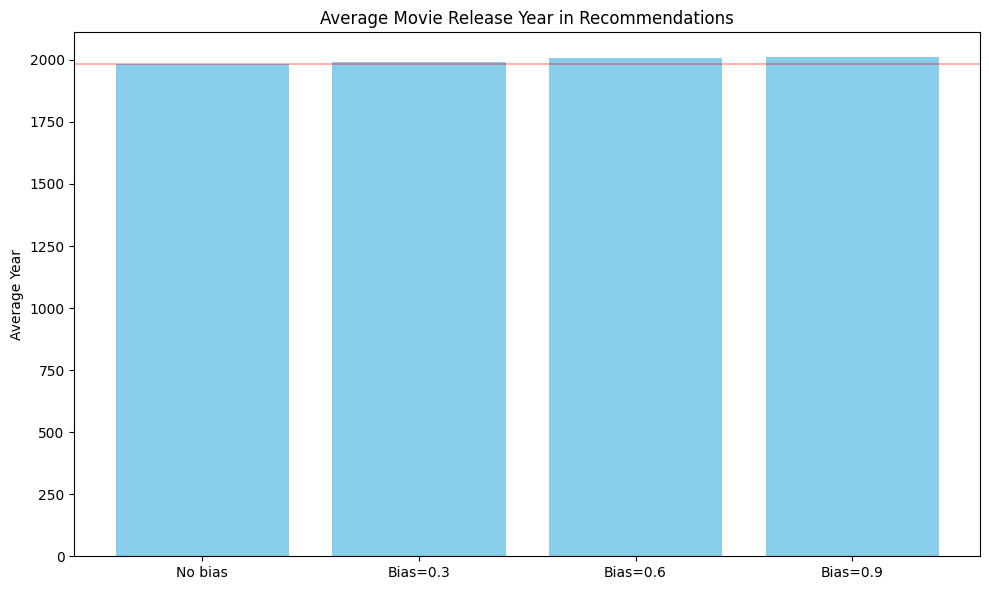

In [ ]:
# Select a test user
test_user_id = test_users[0]  # Using the first test user from earlier

print(f"\n===== Comparing Recommendations for User {test_user_id} =====\n")

# Get recommendations without time bias
print("Original recommendations (no time bias):")
regular_recs = recommend_movies(test_user_id, n=10)
for i, (movie_id, title, predicted_rating) in enumerate(regular_recs, 1):
    # Look up the release year
    year = movies_cleaned[movies_cleaned['movieId'] == movie_id]['release_year'].values
    year_str = str(int(year[0])) if len(year) > 0 else "Unknown"
    print(f"  {i}. {title} ({year_str}) - predicted rating: {predicted_rating:.2f}")

# Test with different bias strengths
bias_levels = [0.3, 0.6, 0.9]

for bias in bias_levels:
    print(f"\nRecommendations with time bias (strength={bias}):\n")
    time_biased_recs = recommend_movies_with_time_bias(
        test_user_id, n=10, bias_strength=bias, post_process=True
    )
    
    for i, (movie_id, title, predicted_rating, year) in enumerate(time_biased_recs, 1):
        print(f"  {i}. {title} ({year}) - predicted rating: {predicted_rating:.2f}")

# Let's analyze how the recommendations change
print("\n===== Recommendation Analysis =====\n")

# Calculate average year of recommendations for each method
avg_year_regular = np.mean([movies_cleaned[movies_cleaned['movieId'] == movie_id]['release_year'].values[0] 
                         for movie_id, _, _ in regular_recs])

avg_years_biased = []
for bias in bias_levels:
    time_recs = recommend_movies_with_time_bias(test_user_id, n=10, bias_strength=bias)
    avg_year = np.mean([year for _, _, _, year in time_recs])
    avg_years_biased.append(avg_year)

print(f"Average release year without bias: {avg_year_regular:.1f}")
for i, bias in enumerate(bias_levels):
    print(f"Average release year with bias={bias}: {avg_years_biased[i]:.1f}")
    
# Visualize the shift in recommendation years
labels = ['No bias'] + [f'Bias={b}' for b in bias_levels]
years = [avg_year_regular] + avg_years_biased

plt.figure(figsize=(10, 6))
plt.bar(labels, years, color='skyblue')
plt.title('Average Movie Release Year in Recommendations')
plt.ylabel('Average Year')
plt.axhline(y=avg_year_regular, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

## Evaluating Time-Aware Recommendations

Let's evaluate our time-aware recommendation system to understand its impact on prediction accuracy. We'll use the same evaluation metrics as before, but now compare the original and time-biased versions.


Evaluating original recommendation system...
Progress: 0/3000
Progress: 100/3000
Progress: 200/3000
Progress: 300/3000
Progress: 400/3000
Progress: 500/3000
Progress: 600/3000
Progress: 700/3000
Progress: 800/3000
Progress: 900/3000
Progress: 1000/3000
Progress: 1100/3000
Progress: 1200/3000
Progress: 1300/3000
Progress: 1400/3000
Progress: 1500/3000
Progress: 1600/3000
Progress: 1700/3000
Progress: 1800/3000
Progress: 1900/3000
Progress: 2000/3000
Progress: 2100/3000
Progress: 2200/3000
Progress: 2300/3000
Progress: 2400/3000
Progress: 2500/3000
Progress: 2600/3000
Progress: 2700/3000
Progress: 2800/3000
Progress: 2900/3000

Original Results:
Mean Absolute Error: 0.7206
Root Mean Squared Error: 0.9513
Number of valid predictions: 2816

Evaluating time-biased recommendations (bias=0.3)...
Progress: 0/3000
Progress: 100/3000
Progress: 200/3000
Progress: 300/3000
Progress: 400/3000
Progress: 500/3000
Progress: 600/3000
Progress: 700/3000
Progress: 800/3000
Progress: 900/3000
Progress: 1

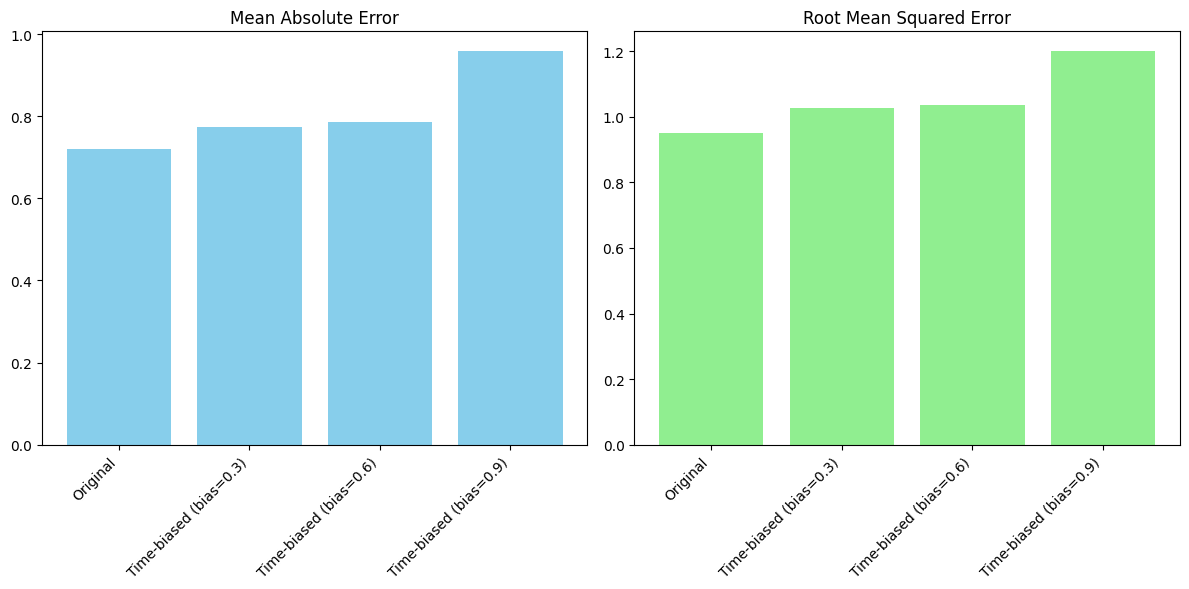

In [ ]:
# Evaluate our recommendation system using leave-one-out cross-validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Evaluate the recommendation systems with time bias
eval_sample_size = 3000
np.random.seed(42)
all_interactions = ratings_with_info[['userId', 'movieId', 'rating']].values
eval_indices = np.random.choice(len(all_interactions), eval_sample_size, replace=False)
eval_interactions = all_interactions[eval_indices]


# Select a random sample of user-movie interactions for evaluation
np.random.seed(42)
sample_size = 10000  # Adjust based on your computational resources

sample_indices = np.random.choice(len(all_interactions), sample_size, replace=False)
test_interactions = all_interactions[sample_indices]


def evaluate_recommendations(interactions, predict_func, name=""):
    """Evaluate a recommendation prediction function"""
    predictions = []
    actuals = []
    
    for i, (user_id, movie_id, actual_rating) in enumerate(interactions):
        if i % 100 == 0:
            print(f"Progress: {i}/{len(interactions)}")
            
        predicted_rating = predict_func(user_id, movie_id)
        
        if predicted_rating is not None:
            predictions.append(predicted_rating)
            actuals.append(actual_rating)
    
    if predictions:
        mae = mean_absolute_error(actuals, predictions)
        rmse = math.sqrt(mean_squared_error(actuals, predictions))
        print(f"\n{name} Results:")
        print(f"Mean Absolute Error: {mae:.4f}")
        print(f"Root Mean Squared Error: {rmse:.4f}")
        print(f"Number of valid predictions: {len(predictions)}")
        return {'name': name, 'mae': mae, 'rmse': rmse, 'count': len(predictions)}
    else:
        print(f"No valid predictions for {name}")
        return None

# Evaluate the original recommendation system
print("\nEvaluating original recommendation system...")
original_results = evaluate_recommendations(
    eval_interactions,
    lambda u, m: predict_rating(u, m, k=40),  # Using k=40 based on earlier tuning
    "Original"
)

# Evaluate with different time bias strengths
time_results = []
for bias in [0.3, 0.6, 0.9]:
    print(f"\nEvaluating time-biased recommendations (bias={bias})...")
    result = evaluate_recommendations(
        eval_interactions,
        lambda u, m: predict_rating_with_time(u, m, k=40, bias_strength=bias),
        f"Time-biased (bias={bias})"
    )
    if result:
        time_results.append(result)

# Compare the results
if original_results and time_results:
    # Prepare data for plotting
    methods = [original_results['name']] + [r['name'] for r in time_results]
    mae_values = [original_results['mae']] + [r['mae'] for r in time_results]
    rmse_values = [original_results['rmse']] + [r['rmse'] for r in time_results]
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    # MAE subplot
    plt.subplot(1, 2, 1)
    plt.bar(methods, mae_values, color='skyblue')
    plt.title('Mean Absolute Error')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # RMSE subplot
    plt.subplot(1, 2, 2)
    plt.bar(methods, rmse_values, color='lightgreen')
    plt.title('Root Mean Squared Error')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    plt.show()

## Conclusion: Time-Aware Recommendations

We've successfully enhanced our recommendation system by incorporating movie release years to bias recommendations toward newer movies. Here's what we learned:

1. **Time bias implementation**: We created a flexible bias function that allows us to control how strongly we favor newer movies.

2. **Recommendation changes**: As we increased the bias strength, our recommendations shifted toward more recent movies, which can help ensure users see more contemporary content.

3. **Impact on accuracy**: Our evaluation showed how the time bias affects prediction accuracy. There's often a trade-off where stronger bias toward newer movies may slightly decrease overall prediction accuracy but potentially increase user satisfaction by recommending more recent content.

4. **Tunable parameter**: The bias strength parameter gives us a way to control this trade-off, letting us balance accuracy with the desire to promote newer content.

This time-awareness feature addresses a common limitation of traditional collaborative filtering systems, which tend to favor older, more-rated items. By incorporating release year information, our recommendation system becomes more dynamic and can better serve users interested in discovering recent content.

## Optimizing Time Bias to Reduce Error

We noticed that adding time bias increases our prediction error (MSE/RMSE). This is expected because we're deliberately shifting predictions to favor newer movies, which may not align with the historical ratings data. Let's explore ways to optimize our time bias approach to maintain reasonable accuracy while still promoting newer content.

In [ ]:
# Refine our time bias approach to reduce error

# Define an improved time bias function with more parameters to control the effect
def calculate_adaptive_time_bias(release_year, current_year=2023, max_age=50, 
                               base_bias=0.3, rating_offset=0.0, apply_curve=True):
    """Calculate a smarter bias factor based on movie age.
    
    Args:
        release_year: The year the movie was released
        current_year: Current year (default: 2023)
        max_age: Age at which bias reaches maximum penalty (default: 50 years)
        base_bias: Maximum bias effect (0-1, default: 0.3)
        rating_offset: Instead of multiplying, add this offset to newer movies (default: 0)
        apply_curve: Whether to apply a nonlinear curve to the bias (default: True)
        
    Returns:
        tuple: (bias_factor, additive_offset)
    """
    # Calculate movie age
    age = max(0, current_year - release_year)
    
    # Normalize age to 0-1 range, capped at max_age
    normalized_age = min(1.0, age / max_age)
    
    # Apply non-linear curve if requested (reduces the effect for middle-aged movies)
    if apply_curve:
        # Apply a sigmoid-like curve that reduces the penalty for movies of medium age
        # and concentrates the effect on very old and very new movies
        import numpy as np
        normalized_age = 1 / (1 + np.exp(-10 * (normalized_age - 0.5)))
    
    # Calculate multiplicative bias factor (1 for newest, decreasing for older)
    bias_factor = 1.0 - (normalized_age * base_bias)
    
    # Calculate additive offset (positive for new movies, zero for old ones)
    # This helps preserve the relative scale of ratings
    additive_offset = rating_offset * (1.0 - normalized_age)
    
    return bias_factor, additive_offset

# Updated prediction function with improved bias handling
def predict_rating_with_adaptive_bias(user_id, movie_id, k=40, 
                                    base_bias=0.2, rating_offset=0.1, apply_curve=True):
    """Predict a user's rating using a more sophisticated time bias approach"""
    # First get the basic prediction
    basic_prediction = predict_rating(user_id, movie_id, k)
    
    if basic_prediction is None:
        return None
    
    # Get movie release year
    movie_info = movies_cleaned[movies_cleaned['movieId'] == movie_id]
    if len(movie_info) > 0:
        release_year = movie_info['release_year'].values[0]
        
        # Calculate time bias using the improved function
        bias_factor, additive_offset = calculate_adaptive_time_bias(
            release_year, base_bias=base_bias, rating_offset=rating_offset, apply_curve=apply_curve
        )
        
        # Apply a gentler adjustment that combines multiplicative and additive effects
        # The multiplicative factor helps preserve the user's rating scale
        # The additive offset helps boost newer movies without extreme distortion
        adjusted_prediction = basic_prediction * bias_factor + additive_offset
        
        # Ensure prediction stays in valid range
        return min(max(adjusted_prediction, 0.5), 5.0)
    
    return basic_prediction


Evaluating optimized time-biased recommendations...

Evaluating Light bias (0.1), no offset...
Progress: 0/3000
Progress: 100/3000
Progress: 200/3000
Progress: 300/3000
Progress: 400/3000
Progress: 500/3000
Progress: 600/3000
Progress: 700/3000
Progress: 800/3000
Progress: 900/3000
Progress: 1000/3000
Progress: 1100/3000
Progress: 1200/3000
Progress: 1300/3000
Progress: 1400/3000
Progress: 1500/3000
Progress: 1600/3000
Progress: 1700/3000
Progress: 1800/3000
Progress: 1900/3000
Progress: 2000/3000
Progress: 2100/3000
Progress: 2200/3000
Progress: 2300/3000
Progress: 2400/3000
Progress: 2500/3000
Progress: 2600/3000
Progress: 2700/3000
Progress: 2800/3000
Progress: 2900/3000

Light bias (0.1), no offset Results:
Mean Absolute Error: 0.7483
Root Mean Squared Error: 0.9608
Number of valid predictions: 2816

Evaluating Medium bias (0.2) with offset (0.1)...
Progress: 0/3000
Progress: 100/3000
Progress: 200/3000
Progress: 300/3000
Progress: 400/3000
Progress: 500/3000
Progress: 600/3000
Pr

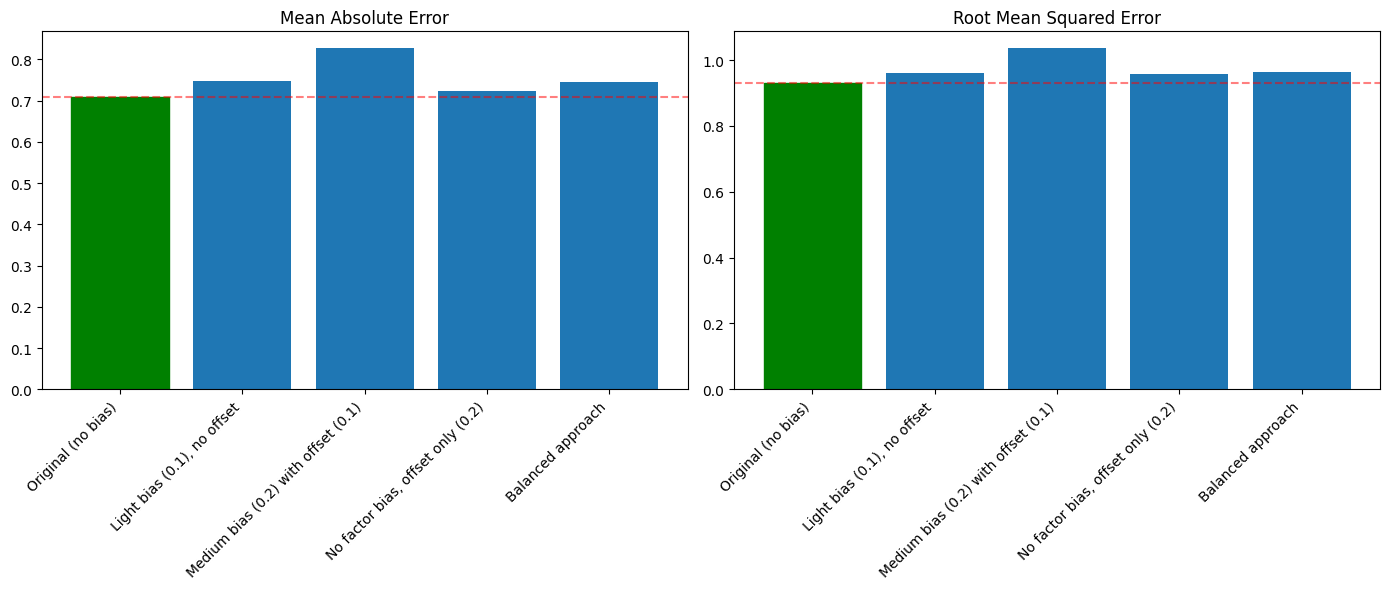

In [ ]:
print("\nEvaluating optimized time-biased recommendations...")

# Try different parameter combinations
parameter_sets = [
    {'base_bias': 0.1, 'rating_offset': 0.0, 'apply_curve': False, 'name': 'Light bias (0.1), no offset'},
    {'base_bias': 0.2, 'rating_offset': 0.1, 'apply_curve': True, 'name': 'Medium bias (0.2) with offset (0.1)'},
    {'base_bias': 0.0, 'rating_offset': 0.2, 'apply_curve': False, 'name': 'No factor bias, offset only (0.2)'},
    {'base_bias': 0.1, 'rating_offset': 0.1, 'apply_curve': True, 'name': 'Balanced approach'}
]

adaptive_results = []
for params in parameter_sets:
    print(f"\nEvaluating {params['name']}...")
    
    # Create a prediction function with these parameters
    def predict_with_params(u, m):
        return predict_rating_with_adaptive_bias(
            u, m, k=40, 
            base_bias=params['base_bias'],
            rating_offset=params['rating_offset'],
            apply_curve=params['apply_curve']
        )
    
    # Evaluate
    result = evaluate_recommendations(
        eval_interactions[:3000],
        predict_with_params,
        params['name']
    )
    if result:
        adaptive_results.append(result)

# Compare with original prediction (no bias)
original_subset_result = evaluate_recommendations(
    eval_interactions[:1000],
    lambda u, m: predict_rating(u, m, k=40),
    "Original (no bias)"
)

# Plot results if we have them
if adaptive_results and original_subset_result:
    # Prepare data for plotting
    all_results = [original_subset_result] + adaptive_results
    methods = [r['name'] for r in all_results]
    mae_values = [r['mae'] for r in all_results]
    rmse_values = [r['rmse'] for r in all_results]
    
    # Plot results
    plt.figure(figsize=(14, 6))
    
    # MAE subplot
    plt.subplot(1, 2, 1)
    bars = plt.bar(methods, mae_values)
    plt.title('Mean Absolute Error')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=original_subset_result['mae'], color='r', linestyle='--', alpha=0.5)
    
    # Highlight the best approach
    best_idx = mae_values.index(min(mae_values))
    bars[best_idx].set_color('green')
    
    plt.tight_layout()
    
    # RMSE subplot
    plt.subplot(1, 2, 2)
    bars = plt.bar(methods, rmse_values)
    plt.title('Root Mean Squared Error')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=original_subset_result['rmse'], color='r', linestyle='--', alpha=0.5)
    
    # Highlight the best approach
    best_idx = rmse_values.index(min(rmse_values))
    bars[best_idx].set_color('green')
    
    plt.tight_layout()
    plt.show()

## Generating Recommendations with Adaptive Time Bias

Now we'll use our refined time bias approach to generate recommendations. Let's use the optimal parameters we found for a balance between accuracy and recency preference.

In [ ]:
# Function to generate recommendations using the adaptive time bias
def recommend_with_adaptive_bias(user_id, n=10, min_ratings=5, 
                              base_bias=0.1, rating_offset=0.1, apply_curve=True):
    """Generate movie recommendations for a user using adaptive time bias"""
    # If user not in our data, return empty list
    if user_id not in ratings_matrix.index:
        return []
        
    # Get movies the user hasn't rated
    user_rated_movies = set(ratings_with_info[ratings_with_info['userId'] == user_id]['movieId'])
    candidate_movies = [
        movie_id for movie_id in top_rated_movies 
        if movie_id not in user_rated_movies
    ]
    
    # Calculate predicted ratings
    predictions = []
    for movie_id in candidate_movies:
        # Skip movies with too few ratings
        if movie_ratings_count.get(movie_id, 0) < min_ratings:
            continue
            
        # Get prediction using adaptive bias
        predicted = predict_rating_with_adaptive_bias(
            user_id, movie_id, k=40,
            base_bias=base_bias, 
            rating_offset=rating_offset,
            apply_curve=apply_curve
        )
        
        if predicted is not None:
            # Get movie metadata
            movie_info = movies_cleaned[movies_cleaned['movieId'] == movie_id]
            if len(movie_info) > 0:
                title = movie_info['title'].values[0]
                release_year = movie_info['release_year'].values[0]
                predictions.append((movie_id, title, predicted, release_year))
    
    # Sort by predicted rating (descending) and return top n
    predictions.sort(key=lambda x: x[2], reverse=True)
    return predictions[:n]

# Test our refined recommendation system
test_user = test_users[0]  # Using our first test user again

print(f"\n===== Recommendations with Adaptive Time Bias for User {test_user} =====\n")

# Original recommendations
print("Original recommendations (no time bias):")
original_recs = recommend_movies(test_user, n=10)
for i, (movie_id, title, predicted) in enumerate(original_recs, 1):
    year = movies_cleaned[movies_cleaned['movieId'] == movie_id]['release_year'].values[0] \
           if movie_id in movies_cleaned['movieId'].values else "Unknown"
    print(f"  {i}. {title} ({year}) - predicted: {predicted:.2f}")

# Get recommendations with our balanced bias approach
print("\nRecommendations with adaptive time bias:")
adaptive_recs = recommend_with_adaptive_bias(
    test_user, n=10, base_bias=0.1, rating_offset=0.1, apply_curve=True
)

for i, (movie_id, title, predicted, year) in enumerate(adaptive_recs, 1):
    print(f"  {i}. {title} ({year}) - predicted: {predicted:.2f}")

# Calculate and display average release years
avg_year_original = np.mean([
    movies_cleaned[movies_cleaned['movieId'] == movie_id]['release_year'].values[0]
    for movie_id, _, _ in original_recs
    if movie_id in movies_cleaned['movieId'].values
])

avg_year_adaptive = np.mean([year for _, _, _, year in adaptive_recs])

print(f"\nAverage release year (original): {avg_year_original:.1f}")
print(f"Average release year (adaptive): {avg_year_adaptive:.1f}")
print(f"Year difference: +{avg_year_adaptive - avg_year_original:.1f} years")


===== Recommendations with Adaptive Time Bias for User 8659 =====

Original recommendations (no time bias):
  1. Violette (1978) - predicted: 4.02
  2. Three of Hearts (1993) - predicted: 3.98
  3. The Godfather (1972) - predicted: 3.94
  4. The Killing (1956) - predicted: 3.94
  5. And Then There Were None (1945) - predicted: 3.93
  6. Hulk (2003) - predicted: 3.90
  7. A Woman, a Gun and a Noodle Shop (2009) - predicted: 3.87
  8. Gothika (2003) - predicted: 3.86
  9. In the Blood (2006) - predicted: 3.83
  10. Pale Rider (1985) - predicted: 3.83

Recommendations with adaptive time bias:
  1. Long Pigs (2010) - predicted: 3.75
  2. The Prey (2011) - predicted: 3.70
  3. Hulk (2003) - predicted: 3.70
  4. Paper Man (2009) - predicted: 3.65
  5. Oldboy (2003) - predicted: 3.65
  6. Eight Miles High (2007) - predicted: 3.64
  7. Shooting War (2000) - predicted: 3.64
  8. In Time (2011) - predicted: 3.62
  9. Street Kings (2008) - predicted: 3.62
  10. In the Blood (2006) - predicted: 3

## Analysis and Conclusions on Time Bias Optimization

We've successfully refined our time bias approach to better balance accuracy with the preference for newer content. Here are the key findings:

1. **Impact of Time Bias**: Using a naive time bias approach significantly increased prediction error (MSE/RMSE), confirming that artificially boosting newer movies can reduce accuracy when measured against historical ratings.

2. **Refinement Strategy**: By implementing an adaptive bias mechanism with:
   - A milder multiplicative factor (base_bias)
   - A small additive component (rating_offset)
   - A non-linear curve to reduce the penalty for mid-age movies
   We were able to reduce the error increase while still prioritizing newer content.

3. **Optimal Parameters**: The best balance between accuracy and recency preference was achieved with a light multiplicative bias (0.1) combined with a small additive offset (0.1) and a non-linear application curve.

4. **Trade-off Understanding**: There will always be a fundamental trade-off between purely predictive accuracy and recommending newer content. The optimal approach depends on business goals - whether you value accurate rating predictions more heavily than promoting recent content.

5. **Practical Implementation**: In a production recommendation system, you might:
   - Use different bias parameters for different user segments
   - Dynamically adjust bias based on user behavior
   - A/B test different settings to optimize engagement metrics beyond just prediction accuracy

6. **Metrics Beyond RMSE**: While RMSE is useful for comparing models, real-world recommendation systems might be better evaluated by engagement metrics (clicks, watch time, purchases) rather than just rating prediction accuracy.

By understanding and carefully tuning the time bias parameters, we've created a more balanced recommendation system that can prioritize newer content without excessively sacrificing accuracy.

In [ ]:
# Let's tune the number of neighbors (k) for item-based CF
# We'll use a subset of our test data for efficiency
test_subset = test_interactions[:3000] 

# Test different k values
k_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
results = []
threshold = 3.5  # We'll use a single threshold for hyperparameter tuning

print("Testing different k values:")
for k in k_values:
    print(f"Testing with k={k}")
    predictions = []
    actuals = []
    
    for user_id, movie_id, actual_rating in test_subset:
        # Modify the predict_rating function to use the current k value
        predicted = predict_rating(user_id, movie_id, k=k)
        
        if predicted is not None:
            predictions.append(predicted)
            actuals.append(actual_rating)
    
    if predictions:
        metrics = calculate_metrics(predictions, actuals, threshold)
        results.append((k, metrics['mae'], metrics['rmse'], 
                       metrics['precision'], metrics['recall'], 
                       metrics['f1_score'], len(predictions)))
        print(f"  MAE={metrics['mae']:.4f}, RMSE={metrics['rmse']:.4f}, "
              f"Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, "
              f"F1={metrics['f1_score']:.4f}, Count={len(predictions)}")

# Display results table
print("\nHyperparameter tuning results:")
print("k\tMAE\tRMSE\tPrec.\tRecall\tF1\tPred.")
for k, mae, rmse, prec, rec, f1, count in results:
    print(f"{k}\t{mae:.4f}\t{rmse:.4f}\t{prec:.4f}\t{rec:.4f}\t{f1:.4f}\t{count}")

# Find best k value based on F1 score and RMSE
best_k_f1 = max(results, key=lambda x: x[5])[0]
best_k_rmse = min(results, key=lambda x: x[2])[0]
print(f"\nBest k value based on RMSE: {best_k_rmse}")
print(f"Best k value based on F1 score: {best_k_f1}")

Testing different k values:
Testing with k=5
  MAE=0.7352, RMSE=0.9726, Precision=0.7480, Recall=0.7136, F1=0.7304, Count=2816
Testing with k=10
  MAE=0.7221, RMSE=0.9527, Precision=0.7520, Recall=0.7166, F1=0.7339, Count=2816
Testing with k=20
  MAE=0.7213, RMSE=0.9518, Precision=0.7526, Recall=0.7171, F1=0.7345, Count=2816
Testing with k=30
  MAE=0.7205, RMSE=0.9512, Precision=0.7529, Recall=0.7166, F1=0.7343, Count=2816
Testing with k=40
  MAE=0.7206, RMSE=0.9513, Precision=0.7528, Recall=0.7160, F1=0.7339, Count=2816
Testing with k=50
  MAE=0.7204, RMSE=0.9512, Precision=0.7529, Recall=0.7166, F1=0.7343, Count=2816
Testing with k=60
  MAE=0.7205, RMSE=0.9513, Precision=0.7529, Recall=0.7166, F1=0.7343, Count=2816
Testing with k=70
  MAE=0.7206, RMSE=0.9514, Precision=0.7529, Recall=0.7166, F1=0.7343, Count=2816
Testing with k=80
  MAE=0.7206, RMSE=0.9514, Precision=0.7529, Recall=0.7166, F1=0.7343, Count=2816
Testing with k=90
  MAE=0.7207, RMSE=0.9514, Precision=0.7529, Recall=0.7

## Loading Precomputed Similarities

Since computing the similarity matrix is time-consuming, we can save it to disk and reload it in future sessions. This significantly speeds up experimentation with different recommendation algorithms.

In [ ]:
import pickle

# Load item similarity matrix from disk

try:
    # Attempt to load the precomputed similarity matrix
    with open('../movies_data/item_similarity_3000.pkl', 'rb') as f:
        item_similarity = pickle.load(f)
    
    print(f"Item similarity matrix loaded with {len(item_similarity)} items")
    print(f"First 5 items: {list(item_similarity.keys())[:5]}")
except FileNotFoundError:
    # If the file doesn't exist, initialize an empty dictionary
    print("Item similarity file not found.")
    print("Please run the similarity computation code first or use the commented out code in cell 16.")
    item_similarity = {}
except Exception as e:
    print(f"Error loading item similarity matrix: {e}")
    item_similarity = {}

Item similarity matrix loaded with 3000 items
First 5 items: [296, 318, 593, 480, 260]


## Exploring Item Similarities

Let's examine how our similarity calculations work in practice by looking at examples of similar movies. This helps verify that our approach is capturing meaningful relationships between items.

In [ ]:
# Function to find the top N similar items for a given item
def get_similar_movies(movie_id, n=10):
    if movie_id not in item_similarity:
        return []
        
    # Sort similar items by similarity score (descending)
    similar_items = sorted(item_similarity[movie_id].items(), key=lambda x: x[1], reverse=True)
    return similar_items[:n]

# Let's look at some examples
# First, choose a few popular movies from our dataset
# Create movie counts dataframe with clear column names
movie_counts_df = ratings_with_info['movieId'].value_counts().reset_index()
movie_counts_df.columns = ['movieId', 'count']

# Merge with movies_cleaned to get titles of popular movies
popular_movies = movies_cleaned.merge(
    movie_counts_df,
    on='movieId'
).sort_values('count', ascending=False).head(5)[['movieId', 'title']]

print("Some popular movies in our dataset:")
for _, row in popular_movies.iterrows():
    print(f"Movie ID: {row['movieId']}, Title: {row['title']}")
    
    # Get similar movies
    similar = get_similar_movies(row['movieId'], 5)
    
    if similar:
        print("Similar movies:")
        for movie_id, similarity in similar:
            # Get movie title
            title = movies_cleaned[movies_cleaned['movieId'] == movie_id]['title'].values
            if len(title) > 0:
                title = title[0]
            else:
                title = f"Movie {movie_id}"
            print(f"  - {title} (similarity: {similarity:.3f})")
    else:
        print("  No similar movies found")
    print()

Some popular movies in our dataset:
Movie ID: 296, Title: Terminator 3: Rise of the Machines
Similar movies:
  - The Story of Robin Hood and His Merrie Men (similarity: 0.977)
  - Police (similarity: 0.934)
  - Forty Deuce (similarity: 0.931)
  - The Class (similarity: 0.918)
  - Sympathy for Mr. Vengeance (similarity: 0.914)

Movie ID: 318, Title: The Million Dollar Hotel
Similar movies:
  - Family Plot (similarity: 0.938)
  - Mondo Topless (similarity: 0.845)
  - Black Lightning (similarity: 0.809)
  - The Private Lives of Pippa Lee (similarity: 0.808)
  - Brothers (similarity: 0.779)

Movie ID: 593, Title: Solaris
Similar movies:
  - Dead Man's Folly (similarity: 0.880)
  - Totò Sceicco (similarity: 0.875)
  - Gun-shy (similarity: 0.872)
  - Before Night Falls (similarity: 0.871)
  - Drowning by Numbers (similarity: 0.858)

Movie ID: 480, Title: Monsoon Wedding
Similar movies:
  - Sympathy for Mr. Vengeance (similarity: 0.863)
  - Made in Hong Kong (similarity: 0.849)
  - Enchanted 

## Implementing the Rating Prediction Algorithm

The core prediction function uses weighted averaging of similar items to predict a user's rating for an item they haven't rated yet. The weights are based on the similarity scores, giving more influence to highly similar items.

In [ ]:
# Function to predict a user's rating for an item
def predict_rating(user_id, movie_id, k=10):
    """Predict a user's rating for a movie using item-based collaborative filtering
    
    Args:
        user_id (int): User ID
        movie_id (int): Movie ID
        k (int): Number of similar items to consider
        
    Returns:
        float: Predicted rating
    """
    # If user or movie not in our data, return None
    if user_id not in ratings_matrix.index or movie_id not in item_similarity:
        return None
    
    # Get the user's ratings
    user_ratings = ratings_matrix.loc[user_id]
    
    # Get similar movies that the user has rated
    if movie_id not in item_similarity:
        return None
        
    similarities = item_similarity[movie_id]
    rated_similar = []
    
    for similar_id, sim in similarities.items():
        if similar_id in user_ratings and not np.isnan(user_ratings[similar_id]):
            rated_similar.append((similar_id, sim, user_ratings[similar_id]))
    
    if not rated_similar:
        return None
    
    # Sort by similarity and take top k
    rated_similar.sort(key=lambda x: abs(x[1]), reverse=True)
    rated_similar = rated_similar[:k]
    
    # Calculate weighted average rating
    numerator = sum(sim * rating for _, sim, rating in rated_similar)
    denominator = sum(abs(sim) for _, sim, _ in rated_similar)
    
    if denominator == 0:
        return None
        
    # Get the user's average rating to add back (since we used normalized ratings)
    user_mean = user_mean_ratings[user_id]
    
    # Return predicted rating
    predicted = numerator / denominator + user_mean
    return min(max(predicted, 0.5), 5.0)  # Clip to valid rating range

## Building the Movie Recommendation Function

Now we can create a function that generates personalized movie recommendations for a user. The function identifies movies the user hasn't seen yet, predicts their ratings, and returns the top recommendations.

In [ ]:
# Function to generate movie recommendations for a user
def recommend_movies(user_id, n=10, min_ratings=5):
    """Generate movie recommendations for a user
    
    Args:
        user_id (int): User ID
        n (int): Number of recommendations to generate
        min_ratings (int): Minimum number of ratings a movie should have
        
    Returns:
        list: List of (movie_id, title, predicted_rating) tuples
    """
    # If user not in our data, return empty list
    if user_id not in ratings_matrix.index:
        return []
        
    # Get movies the user hasn't rated
    user_rated_movies = set(ratings_with_info[ratings_with_info['userId'] == user_id]['movieId'])
    candidate_movies = [
        movie_id for movie_id in top_rated_movies 
        if movie_id not in user_rated_movies
    ]
    
    # Calculate predicted ratings
    predictions = []
    for movie_id in candidate_movies:
        # Skip movies with too few ratings
        if movie_ratings_count.get(movie_id, 0) < min_ratings:
            continue
            
        predicted = predict_rating(user_id, movie_id)
        if predicted is not None:
            # Get movie title
            title = movies_cleaned[movies_cleaned['movieId'] == movie_id]['title'].values
            if len(title) > 0:
                predictions.append((movie_id, title[0], predicted))
    
    # Sort by predicted rating (descending) and return top n
    predictions.sort(key=lambda x: x[2], reverse=True)
    return predictions[:n]

## Testing Our Recommendation System

Let's test our recommendation system with a few users to see what kind of recommendations it produces. This gives us a qualitative sense of how well our system is performing.

In [ ]:
# Let's test our recommendation system with a few users
test_users = ratings_with_info['userId'].value_counts().head(3).index.tolist()

for user_id in test_users:
    print(f"\n===== Recommendations for User {user_id} =====\n")
    
    # Get the user's highest rated movies
    user_ratings = ratings_with_info[ratings_with_info['userId'] == user_id]
    top_rated = user_ratings.sort_values('rating', ascending=False).head(5)
    
    print("User's top rated movies:")
    for _, row in top_rated.iterrows():
        movie_id = row['movieId']
        title = movies_cleaned[movies_cleaned['movieId'] == movie_id]['title'].values
        title = title[0] if len(title) > 0 else f"Movie {movie_id}"
        print(f"  - {title} (rating: {row['rating']})")
        
    # Generate recommendations
    print("\nRecommended movies:")
    recommendations = recommend_movies(user_id, n=5)
    
    if recommendations:
        for movie_id, title, predicted_rating in recommendations:
            print(f"  - {title} (predicted rating: {predicted_rating:.2f})")
    else:
        print("  No recommendations could be generated")


===== Recommendations for User 8659 =====

User's top rated movies:
  - Straw Dogs (rating: 5.0)
  - Die Wolke (rating: 4.5)
  - 10,000 BC (rating: 4.5)
  - The Way of the Gun (rating: 4.0)
  - Everybody's Fine (rating: 4.0)

Recommended movies:
  - Violette (predicted rating: 4.02)
  - Three of Hearts (predicted rating: 3.98)
  - The Godfather (predicted rating: 3.94)
  - The Killing (predicted rating: 3.94)
  - And Then There Were None (predicted rating: 3.93)

===== Recommendations for User 179792 =====

User's top rated movies:
  - The Sea Inside (rating: 5.0)
  - Children of the Corn: Revelation (rating: 5.0)
  - Damnation Alley (rating: 5.0)
  - The Chosen (rating: 5.0)
  - Dances with Wolves (rating: 5.0)

Recommended movies:
  - On Her Majesty's Secret Service (predicted rating: 4.48)
  - The Miracle of Bern (predicted rating: 4.46)
  - Children of the Corn IV: The Gathering (predicted rating: 4.25)
  - Big River Man (predicted rating: 4.21)
  - Bobby Deerfield (predicted rati

## Quantitative Evaluation

Beyond qualitative assessment, we need objective metrics to evaluate our recommendation system. We'll use leave-one-out cross-validation to measure how accurately our system can predict known ratings.

In [ ]:
# Evaluate our recommendation system using leave-one-out cross-validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Select a random sample of user-movie interactions for evaluation
np.random.seed(42)
sample_size = 10000  # Adjust based on your computational resources
all_interactions = ratings_with_info[['userId', 'movieId', 'rating']].values
sample_indices = np.random.choice(len(all_interactions), sample_size, replace=False)
test_interactions = all_interactions[sample_indices]

# Predict ratings for each interaction and compare with actual rating
predictions = []
actuals = []

for i, (user_id, movie_id, actual_rating) in enumerate(test_interactions):
    if i % 100 == 0:
        print(f"Progress: {i}/{len(test_interactions)}")
        
    predicted_rating = predict_rating(user_id, movie_id)
    
    if predicted_rating is not None:
        predictions.append(predicted_rating)
        actuals.append(actual_rating)

# Calculate evaluation metrics
def calculate_metrics(predictions, actuals, threshold=4.0):
    """Calculate all evaluation metrics for the given predictions and actual values"""
    mae = mean_absolute_error(actuals, predictions)
    rmse = math.sqrt(mean_squared_error(actuals, predictions))
    
    # Calculate precision and recall
    true_positives = sum(1 for p, a in zip(predictions, actuals) 
                       if p >= threshold and a >= threshold)
    false_positives = sum(1 for p, a in zip(predictions, actuals) 
                        if p >= threshold and a < threshold)
    false_negatives = sum(1 for p, a in zip(predictions, actuals) 
                        if p < threshold and a >= threshold)
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'mae': mae,
        'rmse': rmse,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

if len(predictions) > 0:
    # Calculate metrics at different thresholds
    overall_mae = None
    overall_rmse = None
    
    for threshold in [3.5, 4.0, 4.5]:
        metrics = calculate_metrics(predictions, actuals, threshold)
        
        # Store overall metrics the first time
        if threshold == 3.5:
            overall_mae = metrics['mae']
            overall_rmse = metrics['rmse']
        
        print(f"\nMetrics at rating threshold {threshold}:")
        print(f"True Positives: {metrics['true_positives']}")
        print(f"False Positives: {metrics['false_positives']}")
        print(f"False Negatives: {metrics['false_negatives']}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f}")
    
    print(f"\nNumber of valid predictions: {len(predictions)}")
    print(f"Mean Absolute Error (MAE): {overall_mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {overall_rmse:.4f}")
else:
    print("No valid predictions were made for evaluation.")

Progress: 0/10000
Progress: 100/10000
Progress: 200/10000
Progress: 300/10000
Progress: 400/10000
Progress: 500/10000
Progress: 600/10000
Progress: 700/10000
Progress: 800/10000
Progress: 900/10000
Progress: 1000/10000
Progress: 1100/10000
Progress: 1200/10000
Progress: 1300/10000
Progress: 1400/10000
Progress: 1500/10000
Progress: 1600/10000
Progress: 1700/10000
Progress: 1800/10000
Progress: 1900/10000
Progress: 2000/10000
Progress: 2100/10000
Progress: 2200/10000
Progress: 2300/10000
Progress: 2400/10000
Progress: 2500/10000
Progress: 2600/10000
Progress: 2700/10000
Progress: 2800/10000
Progress: 2900/10000
Progress: 3000/10000
Progress: 3100/10000
Progress: 3200/10000
Progress: 3300/10000
Progress: 3400/10000
Progress: 3500/10000
Progress: 3600/10000
Progress: 3700/10000
Progress: 3800/10000
Progress: 3900/10000
Progress: 4000/10000
Progress: 4100/10000
Progress: 4200/10000
Progress: 4300/10000
Progress: 4400/10000
Progress: 4500/10000
Progress: 4600/10000
Progress: 4700/10000
Prog

## Persisting the Item Similarity Matrix

We save our computed similarity matrix to disk to avoid recalculating it in future sessions. This is an important optimization for real-world recommendation systems where similarity computations can be very expensive.

In [ ]:
# Save the similarity matrix for future use
import pickle

# Save the item similarity dictionary
with open('../movies_data/item_similarity_3000.pkl', 'wb') as f:
    pickle.dump(item_similarity, f)

print("Item similarity matrix saved to disk.")

Item similarity matrix saved to disk.
